In [2]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler



In [3]:
# ===============================
# 2. LOAD DATASET
# ===============================
df = pd.read_csv("internet_usage_data.csv")


In [4]:
# ===============================
# 3. RENAME COLUMNS (CLEAN NAMES)
# ===============================
df.rename(columns={
    "name": "user_name",
    "start_time": "session_start_time",
    "usage_time": "usage_time",
    "IP": "ip_address",
    "MAC": "mac_address",
    "upload": "upload_mb",
    "download": "download_mb",
    "total_transfer": "total_data_mb",
    "seession_break_reason": "session_break_reason"
}, inplace=True)


In [5]:
# ===============================
# 4. CONVERT USAGE TIME TO MINUTES
# Format: DD:HH:MM:SS
# ===============================
def duration_to_minutes(time_str):
    try:
        days, hours, minutes, seconds = map(int, time_str.split(":"))
        return days*24*60 + hours*60 + minutes + seconds/60
    except:
        return 0

df['usage_duration_minutes'] = df['usage_time'].apply(duration_to_minutes)


In [6]:
# ===============================
# 5. DATETIME CONVERSION
# ===============================
df['session_start_time'] = pd.to_datetime(df['session_start_time'])


In [7]:
# ===============================
# 6. HANDLE MISSING VALUES
# ===============================
df.fillna({
    'upload_mb': 0,
    'download_mb': 0,
    'total_data_mb': 0,
    'usage_duration_minutes': 0
}, inplace=True)


In [8]:
# ===============================
# 7. REMOVE INVALID SESSIONS
# ===============================
df = df[df['usage_duration_minutes'] > 0]


In [9]:
# ===============================
# 8. FEATURE ENGINEERING
# ===============================
df['hour'] = df['session_start_time'].dt.hour
df['day_of_week'] = df['session_start_time'].dt.dayofweek

df['session_intensity'] = df['total_data_mb'] / df['usage_duration_minutes']
df['avg_transfer_rate'] = df['total_data_mb'] / (df['usage_duration_minutes'] * 60)


In [10]:
# ===============================
# 9. TARGET VARIABLE (Network Load Proxy)
# ===============================
# Using total data transferred in a session as a proxy
# for Wi-Fi congestion (higher data = slower Wi-Fi)

df['network_load_mb'] = df['total_data_mb']


In [11]:
# ===============================
# 10. TRAIN-TEST SPLIT
# ===============================
features = [
    'hour',
    'day_of_week',
    'usage_duration_minutes',
    'session_intensity',
    'avg_transfer_rate'
]

X = df[features]
y = df['total_data_mb']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
# ===============================
# 11. TRAIN MODEL
# ===============================
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [13]:
# ===============================
# 12. MODEL EVALUATION
# ===============================
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 35034.35164395543
R² Score: 0.8044449805927532


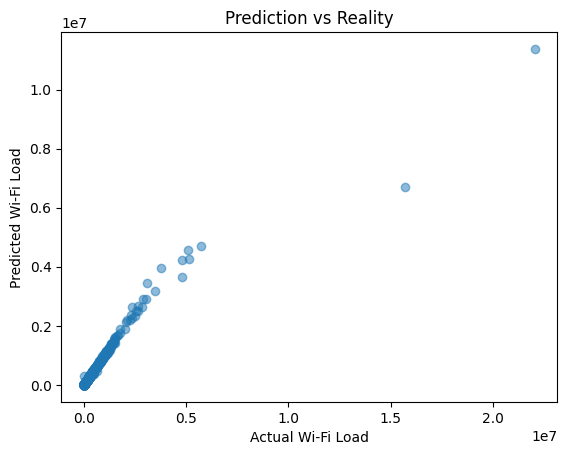

In [14]:
# ===============================
# 13. VISUALIZATION
# ===============================
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Wi-Fi Load")
plt.ylabel("Predicted Wi-Fi Load")
plt.title("Prediction vs Reality")
plt.show()


In [15]:
# ===============================
# 14. USER INTERACTION
# ===============================
def wifi_status(data_mb):
    if data_mb < 50000:
        return "🟢 Fast"
    elif data_mb < 200000:
        return "🟡 Moderate"
    else:
        return "🔴 Very Slow"



def usage_profile(choice):
    if choice == 1:      # Browsing
        return 2000, 50
    elif choice == 2:    # Online class
        return 8000, 200
    elif choice == 3:    # Streaming
        return 20000, 600
    elif choice == 4:    # Heavy download
        return 40000, 1200



In [16]:
#inputs
# 6,2,20,1 for moderate
#15,6,120,3 for low
#4,1,15,1 for fast


In [17]:
print("\n📶 Hostel Wi-Fi Speed Predictor")

hour = int(input("Enter hour (0–23): "))
day = int(input("Enter day of week (0=Mon, 6=Sun): "))
duration = int(input("Expected usage duration (minutes): "))

print("\nUsage Type:")
print("1. Browsing / Social Media")
print("2. Online Class / Zoom")
print("3. Streaming (YouTube / Netflix)")
print("4. Heavy Download / Upload")

choice = int(input("Enter choice (1–4): "))



📶 Hostel Wi-Fi Speed Predictor
Enter hour (0–23): 4
Enter day of week (0=Mon, 6=Sun): 1
Expected usage duration (minutes): 15

Usage Type:
1. Browsing / Social Media
2. Online Class / Zoom
3. Streaming (YouTube / Netflix)
4. Heavy Download / Upload
Enter choice (1–4): 1


In [18]:
session_intensity, avg_transfer_rate = usage_profile(choice)

user_input = [[
    hour,
    day,
    duration,
    session_intensity,
    avg_transfer_rate
]]

predicted_load = model.predict(user_input)[0]

print("\n📊 Prediction Result")
print("Predicted Wi-Fi Load:", round(predicted_load, 3))
print("Wi-Fi Condition:", wifi_status(predicted_load))



📊 Prediction Result
Predicted Wi-Fi Load: 39461.018
Wi-Fi Condition: 🟢 Fast


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



🔥 Worst Wi-Fi Hours (Highest Average Load):
hour
18    665414.452500
1     530880.856788
17    525423.692116
15    517005.111506
14    472403.712765
Name: network_load_mb, dtype: float64


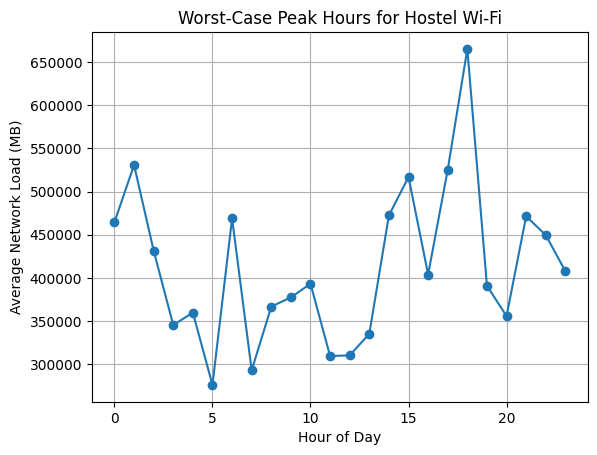

In [22]:
# ===============================
# 15. WORST-CASE PEAK HOURS
# ===============================

# Average network load by hour
hourly_load = df.groupby('hour')['network_load_mb'].mean()

print("\n🔥 Worst Wi-Fi Hours (Highest Average Load):")
print(hourly_load.sort_values(ascending=False).head(5))

# Visualization
plt.figure()
hourly_load.plot(marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Average Network Load (MB)")
plt.title("Worst-Case Peak Hours for Hostel Wi-Fi")
plt.grid(True)
plt.show()



✅ Best Hours for Fast Wi-Fi (Lowest Load):
hour
5     275960.910769
7     292886.830164
11    309492.445992
12    310137.981415
13    335270.579648
Name: network_load_mb, dtype: float64


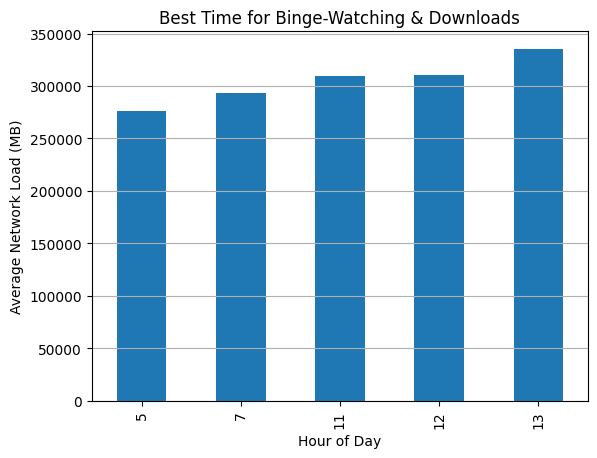

In [20]:
# ===============================
# 16. BEST TIME FOR BINGE-WATCHING / DOWNLOADS
# ===============================

# Lowest average network load hours
best_hours = hourly_load.sort_values().head(5)

print("\n✅ Best Hours for Fast Wi-Fi (Lowest Load):")
print(best_hours)

# Visualization
plt.figure()
best_hours.plot(kind='bar')
plt.xlabel("Hour of Day")
plt.ylabel("Average Network Load (MB)")
plt.title("Best Time for Binge-Watching & Downloads")
plt.grid(axis='y')
plt.show()
